In [1]:
#import neccessary libraries
import numpy as np
import evaluation as ev
import csv
import pandas as pd

In [ ]:
#modified test_single_photon function (taken from test_stats.py) that returns number of clusters
#this function calls our model and tests it using the root file defined in datasets.py in the single_photon_dataset function
#modifications w.r.t evaluations.py:
#-added n_events & noise variables to define number of events & singal threshold each time we call our function
#-added n_clusters variable which gets the length of our clustering array, thus our number of clusters
#-deleted plotly data functions to save compilation time
def n_unique_clusters(n_events, noise):
    tbeta = .2
    td = .5
    nmax = n_events
    yielder = ev.TestYielderSinglePhoton()
    yielder.model.signal_threshold = noise
    n_clusters = np.zeros(shape=(nmax))
    for i, (event, prediction, clustering) in enumerate(yielder.iter_clustering(tbeta, td, nmax=nmax)):
        n_clusters[i] = len(np.unique(clustering))
    return n_clusters

In [ ]:
#set run parameters
n_events = 100
noise_range = range(1,20)
noise_step = 0.05
n_clusters_mean = np.zeros(shape=(len(noise_range)))

#create .csv file to write our results on
with open('cluster_noise_distribution-test.csv', 'w') as f:
    fieldnames = ['noise', 'n_events', 'n_clusters_mean']
    writer = csv.DictWriter(f,fieldnames=fieldnames)
    writer.writeheader()
    #call our function and loop over incremental noise values (step set by noise_step)
    for noise_i in noise_range:
        noise = np.round(noise_i*noise_step,2)
        n_clusters = n_unique_clusters(n_events, noise)
        n_clusters_mean[noise_i] = np.round(np.mean(n_clusters), 2)
        writer.writerow({'noise': noise, 'n_events': n_events, 'n_clusters_mean': n_clusters_mean[noise_i]})
        print(noise_i, noise, n_events, n_clusters, n_clusters_mean[noise_i])

In [2]:
#read our results as a pandas dataframe
df = pd.read_csv('cluster_noise_distribution-test.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   noise            18 non-null     float64
 1   n_events         18 non-null     int64  
 2   n_clusters_mean  18 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 560.0 bytes


In [ ]:
#print out dataframe
df

In [ ]:
#plots results & save as .png
ymin = 0
ymax = np.int(df['n_clusters_mean'].max()) + 5

ax = df.plot('noise', 'n_clusters_mean', 
        kind='bar', 
        title = 'Number of Clusters vs Noise Distribution for photons',
        ylabel = 'Average Number of clusters', 
        xlabel='Signal Threshold',
        rot = 45,
        legend = None,
        figsize=(6, 4))

ax.set_axisbelow(True)
ax.set_ylim([ymin, ymax])
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.get_figure().savefig('cluster_noise_distribution-test.png', bbox_inches = 'tight')

In [5]:
#modifiedtest_single_photon function (taken from test_stats.py) that returns cluster per hit & energy per hit
#this function calls our model and tests it using the root file defined in datasets.py in the single_photon_dataset function
def clusters_info(n_events, noise):
    tbeta = .2
    td = .5
    nmax = n_events
    root_file = 'step3_Gamma_E25_n1000_part9.root' 
    yielder = ev.TestYielderSinglePhoton()
    yielder.model.signal_threshold = noise
    event_n = []
    event_cluster = []
    cluster_energy = []
    cluster_nhits = []
    for i, (event, prediction, clustering) in enumerate(yielder.iter_clustering(tbeta, td, nmax=nmax)):
        #see https://stackoverflow.com/questions/67108215/how-to-get-sum-of-values-in-a-numpy-array-based-on-another-array-with-repetitive
        np.set_printoptions(suppress=True) #suppress scientific notation
        _, idx, _ = np.unique(clustering, return_counts=True, return_inverse=True)
        energy_values = np.round(np.bincount(idx, event.energy),3)
        event_cluster_unique, n_hits = np.unique(clustering, return_counts=True, return_index=False)
        event_i = np.full(len(event_cluster_unique), i, dtype=int)
        event_n = np.append(event_n, event_i)
        event_cluster = np.append(event_cluster, event_cluster_unique)
        cluster_nhits = np.append(cluster_nhits, n_hits)
        cluster_energy = np.append(cluster_energy, energy_values)
    return event_n, event_cluster, cluster_nhits, cluster_energy

In [11]:
#get results for n_events with the noise value where avg number of clusters is minimized
n_events = 100
noise_min = df['noise'][df['n_clusters_mean'].idxmin()]
event_n, event_cluster, cluster_nhits, cluster_energy = clusters_info(n_events,noise_min)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.57it/s]


In [12]:
#create pandas dataframe with resuls from cluster info
ci = event_n, event_cluster, cluster_nhits, cluster_energy
df_ci = pd.DataFrame({'event_n': ci[0], 'event_clusters': ci[1], 'n_hits': ci[2], 'energy_values': ci[3]})
df_ci

,event_n,event_clusters,n_hits,energy_values
0,0.0,0.0,18185.0,144.778
1,0.0,9.0,6.0,0.046
2,0.0,18.0,1.0,0.017
3,0.0,75.0,276.0,23.510
4,1.0,0.0,17719.0,141.664
...,...,...,...,...
227,98.0,0.0,18104.0,145.093
228,98.0,33.0,266.0,26.224
229,99.0,0.0,17863.0,141.402
230,99.0,6.0,2.0,0.121


In [13]:
#calculate percentage of energy by cluster, per event
df_ci['energy_percentage'] = df_ci['energy_values'] / df_ci.groupby('event_n')['energy_values'].transform('sum')
df_ci

,event_n,event_clusters,n_hits,energy_values,energy_percentage
0,0.0,0.0,18185.0,144.778,0.859977
1,0.0,9.0,6.0,0.046,0.000273
2,0.0,18.0,1.0,0.017,0.000101
3,0.0,75.0,276.0,23.510,0.139649
4,1.0,0.0,17719.0,141.664,0.858804
...,...,...,...,...,...
227,98.0,0.0,18104.0,145.093,0.846927
228,98.0,33.0,266.0,26.224,0.153073
229,99.0,0.0,17863.0,141.402,0.852153
230,99.0,6.0,2.0,0.121,0.000729


In [14]:
#get event where energy_percentage is higher than 90%
df_ci[(df_ci['energy_percentage']>0.9)]

,event_n,event_clusters,n_hits,energy_values,energy_percentage


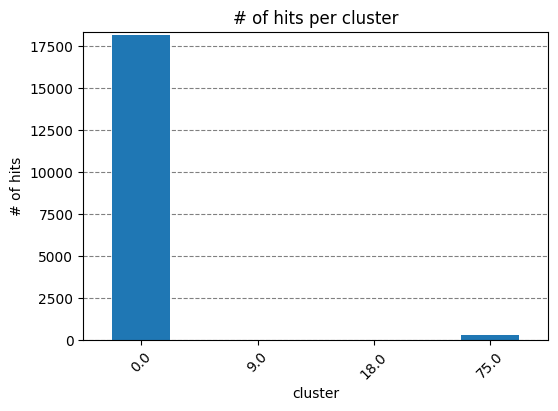

In [18]:
#plots number of htis & save as .png
ymin = 0
ymax = np.int(df_ci['n_hits'].max()) + 5

ax = df_ci[df_ci['event_n']==0.].plot('event_clusters', 'n_hits', 
        kind='bar', 
        title = '# of hits per cluster',
        ylabel = '# of hits', 
        xlabel='cluster',
        rot = 45,
        legend = None,
        figsize=(6, 4))

ax.set_axisbelow(True)
ax.set_ylim([ymin, ymax])
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.get_figure().savefig('cluster_info_nhits-test.png', bbox_inches = 'tight')

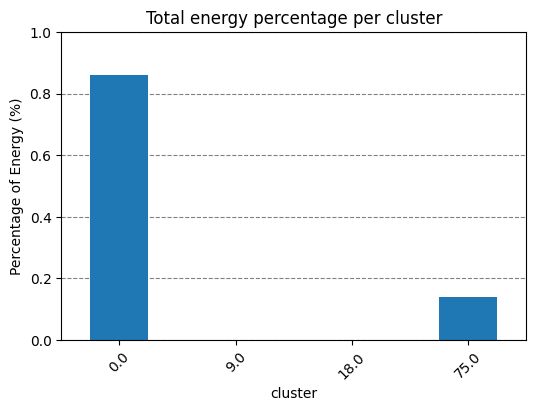

In [21]:
#plots energy values & save as .png
ymin = 0
ymax = 1
ax = df_ci[df_ci['event_n']==0.].plot('event_clusters', 'energy_percentage', 
        kind='bar', 
        title = 'Total energy percentage per cluster',
        ylabel = 'Percentage of Energy (%)', 
        xlabel='cluster',
        rot = 45,
        legend = None,
        figsize=(6, 4))

ax.set_axisbelow(True)
ax.set_ylim([ymin, ymax])
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.get_figure().savefig('cluster_info_energy-test.png', bbox_inches = 'tight')